In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import os
import urllib.request
import pickle
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

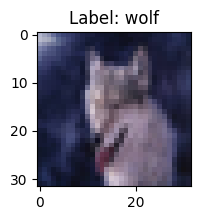

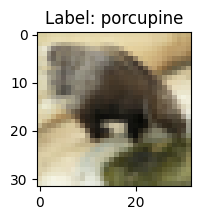

In [23]:
# CIFAR-100 데이터셋 다운로드
url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
urllib.request.urlretrieve(url, filename)

# 압축 풀기
os.system("tar xvzf " + filename)

# 데이터 불러오기
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 메타데이터 불러오기
meta = unpickle('cifar-100-python/meta')
fine_label_names = [t.decode('utf8') for t in meta[b'fine_label_names']]

# 훈련 데이터 불러오기
train = unpickle('cifar-100-python/train')

# trainset : validationset = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(train[b'data'], train[b'fine_labels'], test_size=0.2, random_state=42)

# 이미지 데이터 변환 함수
# -> CIFAR 100의 데이터는 1차원으로 표현이 되기 때문에 plt를 통해 도식화 하려면 위와같이 channel, heigt, width (3차원)으로 바꾸고 다시 순서를 height, width ,channel로 바꾸어준다.
def reshape_image(image):
    return np.transpose(np.reshape(image,(3, 32,32)), (1,2,0))

# 훈련 데이터의 첫 번째 이미지와 레이블 출력
plt.figure(figsize=(2,2))
plt.imshow(reshape_image(x_train[0]))
plt.title('Label: ' + fine_label_names[y_train[0]])
plt.show()

# 검증 데이터의 첫 번째 이미지와 레이블 출력
plt.figure(figsize=(2,2))
plt.imshow(reshape_image(x_val[0]))
plt.title('Label: ' + fine_label_names[y_val[0]])
plt.show()

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# CIFAR-100 데이터를 PyTorch Dataset으로 변환하는 클래스
class CIFAR100Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))  # 이미지 데이터를 (높이, 너비, 채널 수) 형태로 변환, 앞의 -1은 데이터의 갯수
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 데이터를 PyTorch tensor로 변환하고 정규화하는 변환 -> torch로 학습하기 위해 pytorch tensor로 변환
# Tensor로 바꾸는 과정중에 0~255의 범위를 가지는 데이터를 RGB 채널 각각 0.5의 평균과 표준편차로 바꾸어줌
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 훈련 데이터와 검증 데이터를 PyTorch Dataset으로 변환
trainset = CIFAR100Dataset(np.array(x_train), y_train, transform)
valset = CIFAR100Dataset(np.array(x_val), y_val, transform)

# 훈련 세션에 사용할 데이터 파티션
partition = {'train': trainset, 'val': valset}

In [32]:
# backborn model 지정
# VGGnet기반 숫자는 filter size, M은 Max pooling
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

In [33]:
# CNN Architecture 지정

class CNN(nn.Module):

    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()

        # activation function 설정
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.TanH()
        else:
            raise ValueError("Not a valid activation function code")

        # CNN 레이어들을 생성하는 함수 호출하여 레이어 생성
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        # 과적합 방지를 위해 dropout설정하며 이를 classifier에 적용
        self.dropout1 = nn.Dropout(0.7)
        self.classifer = nn.Sequential(nn.Linear(512, 256),
                                       self.act,
                                       self.dropout1,
                                       nn.Linear(256, out_dim))
    # forward 연산 정의
    def forward(self, x):
        x = self.layers(x)        # CNN 레이어들을 통과
        x = x.view(x.size(0), -1) # Flatten 연산, 배치 크기는 유지하고 나머지 차원을 펼침
        x = self.classifer(x)     # Classifier 통과
        return x

    # CNN 레이어들을 생성하는 함수
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                # MaxPooling 레이어 생성
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                # Convolution layer 구성
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,  # out_channels은 forward 연산 이후 x
                                     kernel_size=3,   # CNN kernel_size
                                     stride=1,        # CNN kernel의 stride
                                     padding=1)]      # CNN kernel의 padding

                # BN(Batch Normalization을 사용하는 경우 아래를 사용)
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]   # 레이어 이후 활성화 함수 적용
                in_channels = x        # 다음 들어가야하는 레이어에 입력 채널 수 업데이트

        return nn.Sequential(*layers)  # 생성된 레이어들을 순차적으로 적용하여 모델을 정의(layer 리스트 내의 모든 레이어를 순차적으로 적용하여 하나의 시퀀스로 묶음)

In [34]:
# train session
def train(net, partition, optimizer, criterion, args):
    # trainset을 가져와서 batch_size, shuffle, num_workers(병렬적으로 데이터를 로드)
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train() # 학습모드 설정

    correct = 0 # 맞은 예측 수
    total = 0 # 전체 데이터 수
    train_loss = 0.0 # train_loss
    for i, data in enumerate(trainloader, 0): # 각 배치에 대해 반복
        optimizer.zero_grad() # 옵티마이저 그래디언트 초기화 -> 다음 step으로 가기 위함

        # input(입력 데이터, 레이블)
        inputs, labels = data
        inputs = inputs.cuda() # GPU 연산을 위해 GPU전송
        labels = labels.cuda() # GPU 연산을 위해 GPU전송
        outputs = net(inputs)  # network를 통과한 output값 (예측값)

        loss = criterion(outputs, labels) # loss 계산
        loss.backward() # backpropagaion
        optimizer.step() # optimizer step

        train_loss += loss.item() # loss를 추가
        _, predicted = torch.max(outputs.data, 1) # output에서 가장 높은 확률값의 class 선택
        total += labels.size(0) # 데이터 수 업데이트
        correct += (predicted == labels).sum().item() # predict update(correct)

    train_loss = train_loss / len(trainloader)  # 평균 loss
    train_acc = 100 * correct / total # accuracy
    return net, train_loss, train_acc

In [35]:
# validation seccison
def validate(net, partition, criterion, args):
    # validation set을 가져와서 batch_size, shuffle, num_workers(병렬적으로 데이터를 로드)
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)

    net.eval()  # 네트워크를 평가 모드 -> backprop을 안하기를 위한 목적도 있지만 Dropout이 적용될 경우 적용하지 않기 위함도 존재

    correct = 0 # 맞은 예측 수
    total = 0 # 전체 데이터 수
    val_loss = 0 # validation_loss
    with torch.no_grad(): # graident X
        for data in valloader:  # 배치마다 data 반복
            images, labels = data
            images = images.cuda()  # GPU 연산을 위해 GPU전송
            labels = labels.cuda()  # GPU 연산을 위해 GPU전송
            outputs = net(images)   # network를 통과한 output값 (예측값)

            loss = criterion(outputs, labels) # loss 계산

            val_loss += loss.item() # loss를 추가
            _, predicted = torch.max(outputs.data, 1) # output에서 가장 높은 확률값의 class 선택
            total += labels.size(0) # 데이터 수 업데이트
            correct += (predicted == labels).sum().item() # predict update(correct)

        val_loss = val_loss / len(valloader)  # 평균 loss
        val_acc = 100 * correct / total # accuracy
    return val_loss, val_acc

In [36]:
def experiment(partition, args):

    # CNN model 지정
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn
              )
    # GPU 연산을 위해 cuda로
    net.cuda()

    criterion = nn.CrossEntropyLoss() # loss 계산(class 분류)을 위한 Loss계산법 정의
    if args.optim == 'SGD': # SGD를 사용할 때
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop': # RMSProp를 사용할 때
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':  # Adam를 사용할 때
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice') # 위의 optim을 사용하지 않았을때 Error송출

    # 각 loss, acc에 대해 저장할 리스트 생성
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []


    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()  # 학습시간을 계산하기 위해 초기 시간 기록
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args) # 위에서 정의 한 train function 호출
        val_loss, val_acc = validate(net, partition, criterion, args) # 위에서 정의한 validation
        te = time.time() # 종료 시간 -> 한번 학습이 돌아갔을때의 시간 (te - ts -> 학습시간)

        # 각 loss를 저장함
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 한 epoch당 acc, loss를 뱉어줌
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

        # 매 에폭이 끝날 때마다 모델의 가중치를 저장
        if (epoch + 1) % 10 == 0:
            weight_save_path = f"saved_weights_epoch_{epoch + 1}.pth"  # 에폭에 따른 파일명 생성
            torch.save(net.state_dict(), weight_save_path)

    # 결과를 result에 따로 저장함
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    return vars(args), result

In [37]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']  # exp_name을 가져옴
    del setting['epoch']  # epoch key delete
    del setting['test_batch_size']  # test_batch delete

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]  # 설정을 해싱
    filename = './results/{}-{}.json'.format(exp_name, hash_key)  # 결과를 저장할 파일 경로 지정
    result.update(setting)  # 설정을 result에 update
    with open(filename, 'w') as f:  # exp_name, hash_key를 가지는 파일 이름으로 저장
        json.dump(result, f)

In [38]:
# ====== Random Seed Initialization ====== #
# 동일한 코드를 여러번 실행할 때 동일한 결과를 얻을 수 있는데 이를 방지하기 위함
seed = 123
np.random.seed(seed)  # numpy random seed
torch.manual_seed(seed) # torch random seed

parser = argparse.ArgumentParser()  # 명령행 옵션을 파싱
args = parser.parse_args("")  # 파싱 이후 결과 저장
args.exp_name = "exp1_lr_model_code"  # exp_name 저장

# ====== Model ====== #
args.model_code = 'VGG11'
args.in_channels = 3  # input channel
args.out_dim = 100   # output channel
args.act = 'relu'   # activation function

# ====== Regularization ======= #
args.l2 = 0.01   # L2 Norm
args.use_bn = True  # Batch Normalization

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.00005  # learning rate
args.epoch = 100   # epoch

args.train_batch_size = 512 # train_batch_size
args.test_batch_size = 1024 # test_batch_size

setting, result = experiment(partition, args)
save_exp_result(setting, result)


Epoch 0, Acc(train/val): 3.73/11.38, Loss(train/val) 4.48/4.26. Took 10.28 sec
Epoch 1, Acc(train/val): 8.45/15.80, Loss(train/val) 4.20/3.91. Took 10.41 sec
Epoch 2, Acc(train/val): 12.77/20.82, Loss(train/val) 3.94/3.66. Took 10.14 sec
Epoch 3, Acc(train/val): 16.32/24.66, Loss(train/val) 3.71/3.45. Took 10.23 sec
Epoch 4, Acc(train/val): 20.43/27.75, Loss(train/val) 3.47/3.24. Took 11.08 sec
Epoch 5, Acc(train/val): 24.35/30.15, Loss(train/val) 3.25/3.09. Took 10.38 sec
Epoch 6, Acc(train/val): 28.68/32.12, Loss(train/val) 3.02/2.96. Took 10.47 sec
Epoch 7, Acc(train/val): 32.89/34.25, Loss(train/val) 2.81/2.81. Took 9.95 sec
Epoch 8, Acc(train/val): 37.93/35.85, Loss(train/val) 2.57/2.74. Took 10.07 sec
Epoch 9, Acc(train/val): 42.93/36.56, Loss(train/val) 2.33/2.70. Took 10.13 sec
Epoch 10, Acc(train/val): 48.80/36.23, Loss(train/val) 2.08/2.67. Took 10.20 sec
Epoch 11, Acc(train/val): 55.01/36.94, Loss(train/val) 1.81/2.62. Took 10.42 sec
Epoch 12, Acc(train/val): 61.71/35.98, Lo

KeyboardInterrupt: 